## Chapter 3. The Restricted Two Body Problem

### Action by Diego.A Acosta, University of Antioquia

In this notebook we will present part of the theoretical background of the chapter devoted to the Three body problem and some mathematical and numerical results which are interested for the theory.

For details on the theory please refer directly to the book:

    Murray, C. D., & Dermott, S. F. (1999). Solar system dynamics. Cambridge university press.



### Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
## !pip install spiceypy -q (Collab)
## !pip install celluloid -q (Collab)
from spiceypy import rotate,mxv
from scipy.integrate import odeint
from IPython.core.display import HTML

In [3]:
import matplotlib.animation as animation

### SECTION 3.2 Equation of Motion

the equations of motion in the synodic frame become

$\begin{aligned} \ddot{x}-2 n \dot{y}-n^2 x & =-\left[\mu_1 \frac{x+\mu_2}{r_1^3}+\mu_2 \frac{x-\mu_1}{r_2^3}\right] . \\ \bar{y}+2 \pi \dot{x}-n^2 y & =-\left[\frac{\mu_1}{r_1^3}+\frac{\mu_2}{r_2^3}\right] y . \\ z & =-\left[\frac{\mu_1}{r_1^3}+\frac{\mu_2}{r_2^3}\right] z .\end{aligned}$



*   $x,y,z$ = Position vector
*   $\dot{x}, \dot{y}, \dot{z}$ = Velocity vector
*   $n$ = Mean motion
*   $r_1, r_2$ = Position of test particle respect to $m_1$ and $m_2$
*   $\mu_1$ = 1 - $\mu$
*   $\mu2$ = $\mu$

In [60]:
def CRTBP(Y0,t,mu,dt = 100):
    """
    Numerical solution to Circular Restriced Three Body Problem  
    Arguments:
        Y: Positional vector [x,y,z,vx,vy,vz]
        t: Time of Integration 
        mu: Parameter m2/(m1+m2)
        dt: intervals between t
    Returns:
        Yrot: numpy array of shape (dt,6) with test particle's position in each time
    """
    def equation(Y,t):
        x,y,z,vx,vy,vz = Y
        mu1 = 1-mu
        mu2 = mu
        r1 = np.sqrt((x+mu2)**2 + y**2+z**2)
        r2 = np.sqrt((x-mu1)**2 + y**2+z**2)
        
        mu_r1 = mu1/(r1**3)
        mu_r2 = mu2/(r2**3)

        ax = 2*vy+x-(x+mu2)*mu_r1-(x-mu1)*mu_r2
        ay = -2*vx+y - (mu_r1+mu_r2)*y
        az = -(mu_r1+mu_r2)*z
        
        return [vx, vy, vz, ax, ay, az]

    ts = np.linspace(0,t,dt)

    Yrot = odeint(equation,y0=Y0,t = ts,
                  atol = 1e-10,rtol =1e-10,mxstep=1000)
    return Yrot

A example system

In [33]:
Y0 = np.array([1.1,0,0,-0.1,0.2,0])
t = 30
mu = 0.02
dt = 400
Yrot = CRTBP(Y0,t,mu,dt)

In [54]:
def CRTBP_inertial(Yrot,t,dt):
    """
    Transformation between rotational (synodic) frame to inertial frame
    Arguments:
        Yrot: Positional vector in rotational frame [x,y,z,vx,vy,vz]
        t: Time of Integration 
        dt: intervals between t
    Returns:
        r1: numpy array with shape (dt,3). Position x,y,z of main body with mass m1
        r2: numpy array with shape (dt,3). Position x,y,z of secondary body with mass m3
        YStatic: numpy array with shape (dt,6). Position x,y,z,vx,vy,vz to test Particle
        
    """
    ts = np.linspace(0,t,dt)
    YStatic = np.zeros_like(Yrot)
    r1 = np.zeros_like(Yrot[:,:3])
    r2 = np.zeros_like(Yrot[:,:3])

    for i in range(YStatic.shape[0]):
    
        RMatrix = rotate(-ts[i],3)
        YStatic[i][:3] = mxv(RMatrix,Yrot[i][:3].T)
        YStatic[i][3:] = mxv(RMatrix,Yrot[i][3:]+np.array([-Yrot[i][1],Yrot[i][0],0]))
        
        r1[i] = -mu * np.array([np.cos(ts[i]),np.sin(ts[i]),0])
        r2[i] = (1-mu) * np.array([np.cos(ts[i]),np.sin(ts[i]),0])
    return r1,r2,YStatic

In [55]:
r1, r2, YStatic = CRTBP_inertial(Yrot,t,dt)

#### Animation of the movement in both frames

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)


def graph_orbit(ti):
    global  Yrot, YStatic
    ax1.cla()
    ax2.cla()
    ax1.plot(YStatic[ti,0],YStatic[ti,1],'bo')
    ax1.plot(YStatic[:ti,0],YStatic[:ti,1],'b--')
    ax1.plot(r1[ti,0],r1[ti,1],'ro')
    ax1.plot(r2[ti,0],r2[ti,1],'go')
    ax1.set_xlim(min(YStatic[:,0]),max(YStatic[:,0]))
    ax1.set_ylim(min(YStatic[:,1]),max(YStatic[:,1]))
    ax1.set_xlabel('x (Lenght units)')
    ax1.set_ylabel('y (Lenght units)')
    ax1.set_title('Inertial Frame')

    ax2.plot(Yrot[ti,0],Yrot[ti,1],'bo')
    ax2.plot(Yrot[:ti,0],Yrot[:ti,1],'b--')
    ax2.plot(mu,0,'ro')
    ax2.plot(1-mu,0,'go')
    ax2.set_xlim(min(Yrot[:,0]),max(Yrot[:,0]))
    ax2.set_ylim(min(Yrot[:,1]),max(Yrot[:,1]))
    ax2.set_xlabel('x (Lenght units)')
    ax2.set_ylabel('y (Lenght units)')
    ax2.set_title('Rotating Frame')



anim = animation.FuncAnimation(fig, graph_orbit,frames = np.arange(dt), blit=False, interval=50,
                              repeat=True) 
plt.close()

In [57]:
anim.save('animations/demostration_system.mp4')

### SECTION 3.3 Jacobi Integral

**Since this point, we assume z = 0**

The Jacobi constant give us an expression to find where a particle can goes by setting his speed bigger than zero and find those regions where this happens 

In [46]:
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)

X,Y = np.meshgrid(x,y)
mu = 0.02
mu1 = 1-mu
mu2 = mu


Using the same last system, $\mu = 0.02$.  $r_0 = [1.1, 0, 0]$, $v_0 = [-0.1,0.2,0]$

This problem must respect the Jacobi Constant, here we show the value of the constant in the past of time

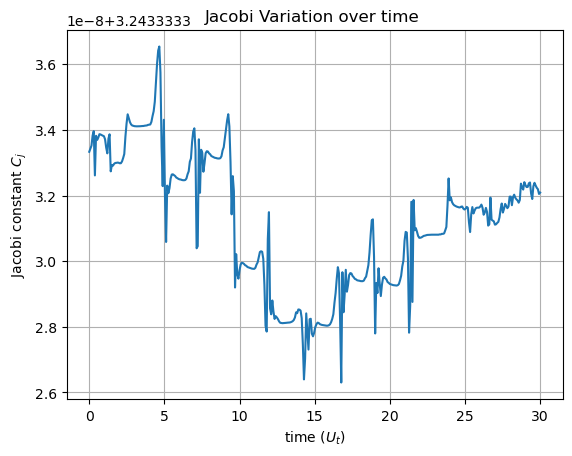

In [47]:
xrot = Yrot[:,0]
yrot = Yrot[:,1]
vxrot = Yrot[:,3]
vyrot = Yrot[:,4]

r1 = np.sqrt((xrot+mu2)**2+yrot**2)
r2 = np.sqrt((xrot-mu1)**2+yrot**2)

Cj = xrot**2+yrot**2+2*(mu1/r1+mu2/r2) -vxrot**2-vyrot**2

fig, ax = plt.subplots()
ax.plot(np.linspace(0,t,dt),Cj)
ax.set_xlabel(r'time ($U_t$)')
ax.set_ylabel(r'Jacobi constant $C_j$')
ax.grid()
ax.set_title('Jacobi Variation over time ')
plt.show()

Jacobi constant is preserved over time with fluctuations generated by numerical integration

The regions a particle can reach are the ones with  $0\leq v$. In the Jacobi expression:

$$
x^2+y^2+2\left( \frac{\mu_1}{r_1} + \frac{\mu_2}{r_2}\right) = C_j
$$

#### Animated demostration of excluded regions

In [12]:
Cj = 3.245
mu1 = 1-mu
mu2 = mu

r1 = np.sqrt((X+mu2)**2+Y**2)
r2 = np.sqrt((X-mu1)**2+Y**2)

Z = X**2+Y**2+2*(mu1/r1+mu2/r2)-Cj

In [50]:
fig, ax = plt.subplots()
def graph_excluded(ti):
    ax.cla()
    ax.contour(X,Y,Z,levels=[0],colors='k',alpha = 0.3)
    ax.contourf(X,Y,Z,levels=[-100,0],colors='k',alpha = 0.2)
    ax.plot(Yrot[ti,0],Yrot[ti,1],'bo',markersize = 0.1)
    ax.plot(Yrot[:ti,0],Yrot[:ti,1],'b--',markersize = 0.1)
    ax.plot(-mu2,0,'ro')
    ax.plot(mu1,0,'go')
    ax.plot()
    ax.set_ylim(-2,2)
    ax.set_xlim(-2,2)
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.set_title('Excluded Regions $\mu = {}$'.format(mu))


anim = animation.FuncAnimation(fig, graph_excluded,frames = np.arange(dt), blit=False, interval=50,
                              repeat=True) 
plt.close()

In [51]:
anim.save('animations/excluded_regions.mp4')

### SECTION 3.4 Tisserand Relation

\begin{equation}
\frac{1}{2a}+ \sqrt{a(1-e^2)}\cos{I} \approx constant
\end{equation}

The value of $h\cos{I}$ is obtained with. 

\begin{equation}
\vec{v_S} \cdot (\vec{e_z}\times \vec{r_S}) = h\cos{I}
\end{equation}

We named here $\vec{v_S}, \vec{r_S}$ the sidereal position and velocity respectively

For a small value of $\mu$, in this case $0.02$, the tisserand relation is not a good aproximation

In [15]:
hcos  = np.zeros(dt)
for i in range(dt):
    hcos[i] = np.dot(YStatic[i,3:],np.cross([0,0,1],YStatic[i,:3]))

In [16]:
velocity_m = np.linalg.norm(YStatic[:,3:],axis = 1)
position_m = np.linalg.norm(YStatic[:,:3],axis = 1)
tisserand = hcos+(1/2)*(2/position_m-velocity_m**2)

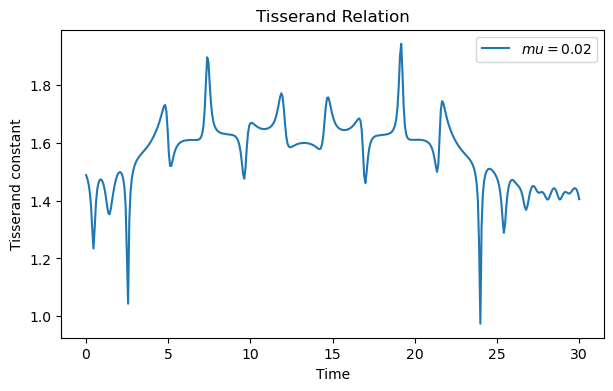

In [17]:
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(np.linspace(0,t,dt),tisserand, label = r'$mu = 0.02$'.format(mu) )
ax.set_xlabel('Time')
ax.set_ylabel('Tisserand constant')
ax.set_title('Tisserand Relation')
ax.legend()
plt.show()

When we reduce the value of $\mu$, the tisserand parameter varies less

In [18]:
mu_s = [1e-3,1e-4,1e-5]

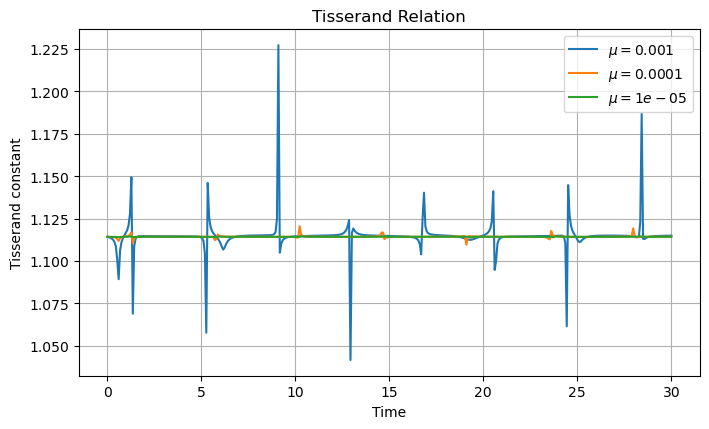

In [19]:
fig, ax = plt.subplots(figsize = (7,4))
Y0 = [1.2,0.5,0,0,-1,0]
for mu in mu_s:
    Y_try = CRTBP(Y0,t,mu,dt)
    Y_try_inertial = CRTBP_inertial(Y_try,t,dt)[2]
    hcos  = np.zeros(dt)
    for i in range(dt):
        hcos[i] = np.dot(Y_try_inertial[i,3:],np.cross([0,0,1],Y_try_inertial[i,:3]))
    velocity_m = np.linalg.norm(Y_try_inertial[:,3:],axis = 1)
    position_m = np.linalg.norm(Y_try_inertial[:,:3],axis = 1)
    tisserand = hcos+(1/2)*(2/position_m-velocity_m**2)
    ax.plot(np.linspace(0,t,dt),tisserand,label = r'$\mu = {}$'.format(mu))
    plt.tight_layout()
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Tisserand constant')
ax.set_title('Tisserand Relation')
ax.grid()
plt.show()

### SECTION 3.5 Lagrangian Equilibrium Points

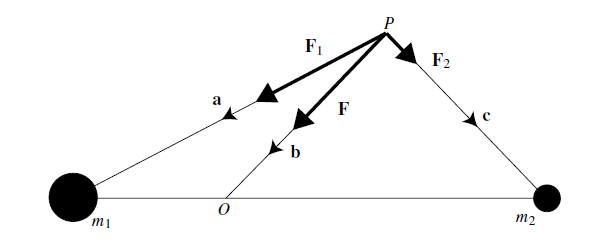

With the same schema we got in the Fig 3.5, Taking the vector product of $\overrightarrow{F_1}+\vec{F}_2$ with eq (3.50)

There are three considerations here. 

$
\overrightarrow{F_1} \parallel \vec{a} \\
\overrightarrow{F_2} \parallel \vec{c} \\
\overrightarrow{F_1}+ \overrightarrow{F_2} \parallel \vec{b}
$

\begin{aligned}
M_1(\vec{a}-\vec{b})&=M_2(\vec{b}-\vec{c}) \qquad \times  \quad  \overrightarrow{F_1}+\vec{F}_2 \\
\left(\overrightarrow{F_1}+\vec{F}_2\right) \times m_1(\vec{a}-\vec{b})&=\left(\vec{F}_1+\vec{F}_2\right) \times M_2(\vec{b}-\vec{c}) \\
m_1\left(\left(\vec{F}_1+\vec{F}_2\right) \times \vec{a}-\left(\vec{F}_1+\vec{F}_2\right) \times \vec{b}\right)&=M_2\left(\left(\vec{F}_1+\vec{F}_2\right) \times \vec{b}-\left(\vec{F}_1+\vec{F}_2\right) \times \vec{c}\right) \\
M_1\left(\vec{F}_2 \times \vec{a}\right)&=M_2\left(-\vec{F}_2 \times \vec{c}\right) \\
M_1\left(\vec{F}_2 \times \vec{a}\right)+M_2(\vec{F_1} \times \vec{c})&=0
\end{aligned}

### SECTION 3.6 Location of Equilibrium Points

By doing the velocity zero and aceleration zero whe can find points where the particles are in equilibrium, these are named The Lagrangian Equilibrium points

$$ U=\mu_1\left(\frac{1}{r_1}+\frac{r_1^2}{2}\right)+\mu_2\left(\frac{1}{r_2}+\frac{r_2^2}{2}\right)-\frac{1}{2} \mu_1 \mu_2$$


Finding the derivatives respect to $x$ and $y$ we can find to points  with a trivial solution.

These points are $L_4, L_5$
$$
x = \frac{1}{2}-\mu_2 \qquad y = \pm \frac{\sqrt{3}}{2}
$$

Using

$ \alpha = \left(\frac{\mu_2}{3\mu_1}\right)^{1/3}$

For $L_1$,  $\qquad r_2 = -x + \mu_1$
$$
r_2 = \alpha - \frac{\alpha^2}{3} - \frac{\alpha^3}{9} - \frac{23\alpha^4}{81} + \mathcal{O}(\alpha^5)
$$
For $L_2$,  $\qquad r_2 = x + \mu_2$
$$
r_2 = \alpha + \frac{\alpha^2}{3} - \frac{\alpha^3}{9} - \frac{31\alpha^4}{81} + \mathcal{O}(\alpha^5)
$$
For $L_3$,  $\qquad r_1 = -x - \mu_2$
$$
r_1-1 = -\frac{7}{12}\left( \frac{\mu_2}{\mu_1}\right)  + \frac{7}{12}\left( \frac{\mu_2}{\mu_1}\right)^2 - \frac{13223}{20736}\left( \frac{\mu_2}{\mu_1}\right)^3  + \mathcal{O}\left( \frac{\mu_2}{\mu_1}\right)^4
$$

In [64]:
def Lagrange(mu):
    """ Locations of System's Lagrange Points 

    Args:
        mu (int): Gr

    Returns:
        L1: x component of Lagrange Point L1 (colinear)
        L2: x component of Lagrange Point L2 (colinear)
        L3: x component of Lagrange Point L3 (colinear)
        L4: [x,y] components of Lagrange Point L4 (y > 0)
        L5: [x,y] components of Lagrange Point L5 (y < 0)
    """
    mu1 = 1- mu
    mu2 = mu
    alpha = (mu2/(3*mu1))**(1/3)
    L1 = mu1 -( alpha -(alpha**2)/3 -(alpha**3)/9-(alpha**4)*(23/81))
    L2 = mu1  + ( alpha +(alpha**2)/3 -(alpha**3)/9-(alpha**4)*(31/81))
    mu2mu1 = mu2/mu1
    L3 = -mu2 - 1 -(-(7/12)*(mu2mu1)+(7/12)*((mu2mu1)**2) -(13223/20736)*((mu2mu1)**3))
    L4 = 1/2 - mu2
    L5 = L4
    return L1,L2,L3,[L4,np.sqrt(3)/2],[L5,-np.sqrt(3)/2]

The location of the Lagrangian equilibrium points and associated zero-velocity curves for μ2 = 0.2. The plot shows the zero-velocity curves for the three critical values of the Jacobi constant (3.805, 3.552,
3.197)

And visualization of minus Jacobi constant with the placements of Lagrange Points

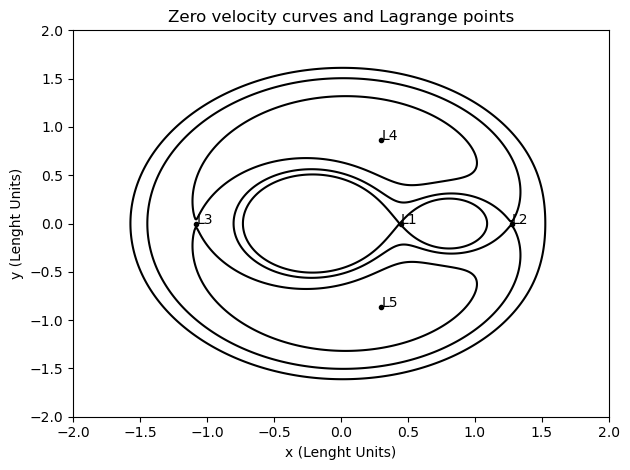

In [91]:
mu = 0.2
mu1 = 1-mu
mu2 = mu

x = np.linspace(-2,2,500)
y = np.linspace(-2,2,500)

X,Y = np.meshgrid(x,y)
r1 = np.sqrt((X+mu2)**2+Y**2)
r2 = np.sqrt((X-mu1)**2+Y**2)

Cj = X**2+Y**2+2*(mu1/r1+mu2/r2)

L = Lagrange(mu)



fig, ax = plt.subplots()
lines = ax.contour(X,Y,Cj,levels = [3.197,3.552,3.805],colors = 'k')

for i in range(5):
    if i < 3:
        ax.plot(L[i],0,'ko',markersize = 3,)
        ax.text(L[i],0,'L{}'.format(i+1))
    else:
        ax.plot(L[i][0],L[i][1],'ko',markersize = 3)
        ax.text(L[i][0],L[i][1],'L{}'.format(i+1))
    ax.set_xlabel('x (Lenght Units)')
    ax.set_ylabel('y (Lenght Units)')
ax.set_title('Zero velocity curves and Lagrange points')
plt.tight_layout()
plt.show()

**Animation of $-JC$ surfaces respect to $\mu$** 

In [135]:
mu = np.linspace(0.000001,0.2,50)
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

def graph_jc(mu):
    ax.cla()
    mu1 = 1-mu
    mu2 = mu

    x = np.linspace(-1,2,100)
    y = np.linspace(-2,2,100)
    X,Y = np.meshgrid(x,y)

    r1 = np.sqrt((X+mu2)**2+Y**2)
    r2 = np.sqrt((X-mu1)**2+Y**2)

    Cj = X**2+Y**2+2*(mu1/r1+mu2/r2)
    Cj = np.where(-Cj > -6,Cj,np.nan)

    ax.plot_surface(X,Y,-Cj,cmap = 'inferno')
    for i in range(5):
        if i < 3:  
            r1 = np.sqrt((L[i]+mu2)**2)
            r2 = np.sqrt((L[i]-mu1)**2)
            Cj = L[i]**2+2*(mu1/r1+mu2/r2)
            ax.plot(L[i],0,-Cj,'ko',markersize = 5)
            ax.text(L[i],0,-Cj,'L{}'.format(i+1))
        else:
            r1 = np.sqrt((L[i][0]+mu2)**2+L[i][1]**2)
            r2 = np.sqrt((L[i][0]-mu1)**2+L[i][1]**2)
            Cj = L[i][1]**2+L[i][0]**2+2*(mu1/r1+mu2/r2)
            ax.plot(L[i][0],L[i][1],-Cj,'ko',markersize = 5)
            ax.text(L[i][0],L[i][1],-Cj,'L{}'.format(i+1))
    ax.set_title(r'$\mu = {}$'.format(round(mu,3)))

    ax.set_zlim3d(-5,2)
    ax.view_init(50,-30,0)
    ax.set_axis_off()

anim = animation.FuncAnimation(fig, graph_jc,frames = mu, blit=False, interval=50,
                              repeat=True) 
plt.close()

In [136]:
anim.save('animations/jacobi_surface.mp4')

### SECTION 3.7 Stability of Equilibrium Points